# 1. Packages

In [1]:
# Data Structures
import numpy as np

# Data Visualizations
import matplotlib.pyplot as plt

# Statistic
from scipy.stats import boxcox

# PySpark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan

In [2]:
spark = SparkSession.builder.appName("String").getOrCreate()

In [3]:
spark

# 2. The Dataset

In [4]:
loan = spark.read.csv('LoanStats_2018Q1.csv', inferSchema = True, header = True)

In [5]:
# 107868 records and 145 columns
print(loan.count())
print(len(loan.columns))

107868
145


In [6]:
# Data Schema
loan.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: doub

In [7]:
# The goal is to predict the loan status for each loan application.
# 4 records were missing.
loan.filter((loan["loan_status"] == "") | loan["loan_status"].isNull() | isnan(loan["loan_status"])).\
select('loan_status').show()
print('{} records were missing under the loan_status column.'.format(
    loan.filter((loan["loan_status"] == "") | loan["loan_status"].isNull() | isnan(loan["loan_status"])).count())
     )

+-----------+
|loan_status|
+-----------+
|       null|
|       null|
|       null|
|       null|
+-----------+

4 records were missing under the loan_status column.


In [8]:
loan = loan.na.drop(subset = ["loan_status"])
print('Drop 4 missing records, now {} records left.'.format(loan.count()))

Drop 4 missing records, now 107864 records left.


# 3. Exploratory Data Analysis (EDA)
- 3.1 Response variable: loan_status
- 3.2 User related features (basic information)
- 3.3 User related feature (financial specific - income)
- 3.4 Loan general feature

## 3.1 Response variable: loan_status
- Description: Current status of the loan. loan_status contains six levels.
- Summary: Need to use oversampling techniques to address unbalanced lables on minority levels.

In [9]:
sqlCtx.registerDataFrameAsTable(loan, "loan")

In [10]:
df1 = sqlCtx.sql("SELECT loan_status FROM loan")

Text(0.5, 1.0, 'loan_status')

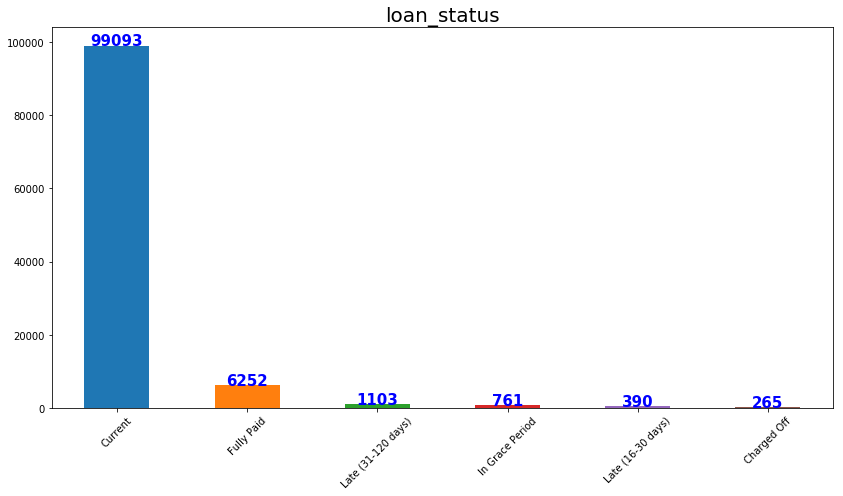

In [11]:
fig = plt.figure(figsize=(14,7))
ax = df1.toPandas().loan_status.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df1.toPandas().loan_status.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('loan_status',fontsize=20)

In [12]:
del df1

## 3.2 User related features (basic information)

### 3.2.1 new_addr_state
- Description: The state provided by the borrower in the loan application.
- Transformation: Transform addr_state into five levels including west, midwest, southwest, southeast, and northeast.

In [13]:
# Mapping reference
us_state_map = {'west': ['WA', 'OR', 'ID', 'MT', 'WY', 
                         'CA', 'NV', 'UT', 'CO',
                         'AK', 'HI'],
                'midwest': ['ND', 'SD', 'NE', 'KS', 'MN',
                            'IA', 'MO', 'WI', 'IL', 'MI',
                            'IN', 'OH'],
                'southwest': ['AZ', 'NM', 'OK', 'TX'],
                'southeast': ['KY', 'WV', 'DC', 'VA', 'AR',
                              'LA', 'TN', 'NC', 'MS', 'AL',
                              'GA', 'SC', 'FL'],
                'northeast': ['PA', 'MD', 'NY', 'VT', 'ME',
                              'NH', 'MA', 'RI', 'CT', 'NJ',
                              'DE']
               }

In [14]:
df2 = spark.sql("SELECT CASE WHEN addr_state IN ('WA','OR','ID','MT','WY','CA','NV','UT','CO','AK','HI') THEN 'west' \
WHEN addr_state IN ('ND','SD','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH') THEN 'midwest' \
WHEN addr_state IN ('AZ','NM','OK','TX') THEN 'southwest' \
WHEN addr_state IN ('KY','WV', 'DC','VA','AR','LA','TN','NC','MS','AL','GA','SC','FL') THEN 'southeast' \
ELSE 'northeast'END AS new_addr_state, loan_status FROM loan")

Text(0.5, 1.0, '3.2.1 new_addr_state')

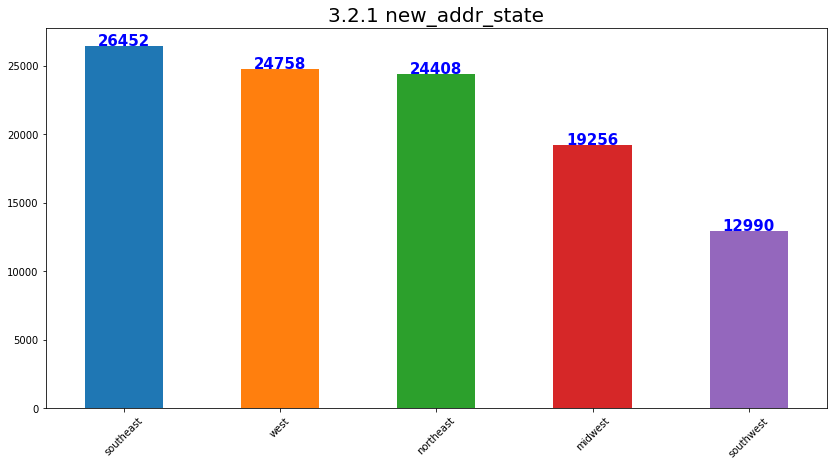

In [15]:
fig = plt.figure(figsize=(14,7))
ax = df2.toPandas().new_addr_state.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df2.toPandas().new_addr_state.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.2.1 new_addr_state',fontsize=20)

In [16]:
sqlCtx.registerDataFrameAsTable(df2, "df2")

In [17]:
state_southeast = spark.sql("SELECT loan_status FROM df2 WHERE new_addr_state IN ('southeast')")
state_west = spark.sql("SELECT loan_status FROM df2 WHERE new_addr_state IN ('west')")
state_northeast = spark.sql("SELECT loan_status FROM df2 WHERE new_addr_state IN ('northeast')")
state_midwest = spark.sql("SELECT loan_status FROM df2 WHERE new_addr_state IN ('midwest')")
state_southwest = spark.sql("SELECT loan_status FROM df2 WHERE new_addr_state IN ('southwest')")

In [18]:
# Helper function for plotting relationship between two categorical variables.
def plot_cate_to_cate(data,total_count,predictor,response,legend_names):
    # The first two levels of loan_status
    fig = plt.figure(figsize=(16,7))
    
    ax = fig.add_subplot(121)
    ind = np.arange(2)
    width = 0.1
    
    for i in range(0, len(data)):
        ax.bar(ind+width, data[i].toPandas()[response].value_counts()[:2]/total_count[:2], 0.1)
        width+=0.1
        
    ax.set_ylabel('Count Frequency (in %)')
    ax.set_title(predictor + ' by group and ' + response)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(data[i].toPandas()[response].value_counts()[:2].index[:])
    ax.legend(legend_names, loc='upper right')
    
    # The rest four levels of loan_status
    ax = fig.add_subplot(122)
    ind = np.arange(4)
    width = 0.1

    for i in range(0, len(data)):
        ax.bar(ind+width, data[i].toPandas()[response].value_counts()[2:]/total_count[2:], 0.1)
        width+=0.1

    ax.set_ylabel('Count Frequency (in %)')
    ax.set_title(predictor + ' by group and ' + response)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(data[i].toPandas()[response].value_counts()[2:].index[:])
    ax.legend(legend_names,loc='upper right')

#### Relationship between new_addr_state and loan_status
- Summary
    1. southeast (blue), west (orange), and northeast (green) are states which are currently paying loans and already fully paid loans because they ranked in the top 3. However, these states ranked in the top 3 across the rest of levels.
    
    2. midwest (red) and southest (purple): Seems to have a similar distribution on the loan_status. There is a fix difference between these two states across six levels of loan_status except the level, 'Fully Paid'.

In [19]:
total_count = []
levels = state_southeast.toPandas()['loan_status'].value_counts().index.tolist()
for each in levels:
    total_count.append((df2.select('loan_status').toPandas()['loan_status'] == each).sum())

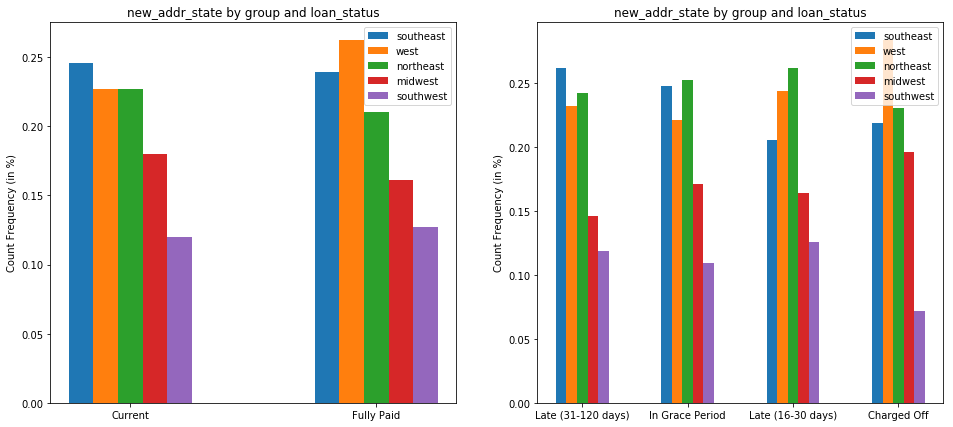

In [20]:
plot_cate_to_cate(data=[state_southeast,state_west,state_northeast,state_midwest,state_southwest],
                  total_count=total_count,
                  predictor='new_addr_state',
                  response='loan_status',
                  legend_names=['southeast','west','northeast','midwest','southwest'])

### 3.2.2 new_emp_length
- Description: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
- Transformation: Transform emp_length into four levels including na_experience, junior, more_experienced, and experienced according to the years.

In [21]:
df3 = loan.select('emp_length')

Text(0.5, 1.0, '3.2.2 emp_length')

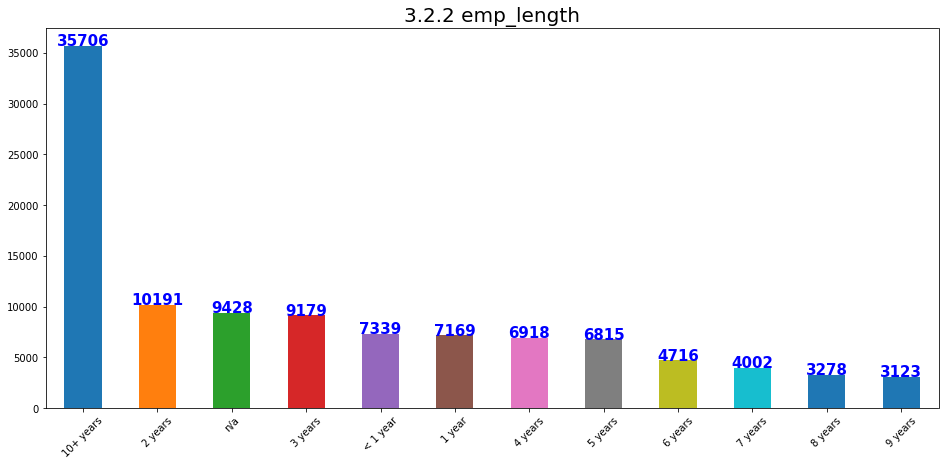

In [22]:
fig = plt.figure(figsize=(16,7))
ax = df3.toPandas().emp_length.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df3.toPandas().emp_length.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.2.2 emp_length',fontsize=20)

In [23]:
del df3

In [24]:
query_4 = "SELECT CASE WHEN emp_length IN ('< 1 year','1 year','2 years','3 years') THEN 'junior' \
WHEN emp_length IN ('4 years', '5 years') THEN 'more_experienced' \
WHEN emp_length IN ('n/a') THEN 'na_experience' \
ELSE 'experienced' END AS new_emp_length, loan_status FROM loan"

In [25]:
df4 = spark.sql(query_4)

In [26]:
sqlCtx.registerDataFrameAsTable(df4, "df4")

#### new_emp_length
- Summary: Loan applicants mainly came from those who are experienced in terms of their careers with the junior level and more experienced as the followings.

Text(0.5, 1.0, '3.2.3 new_emp_length')

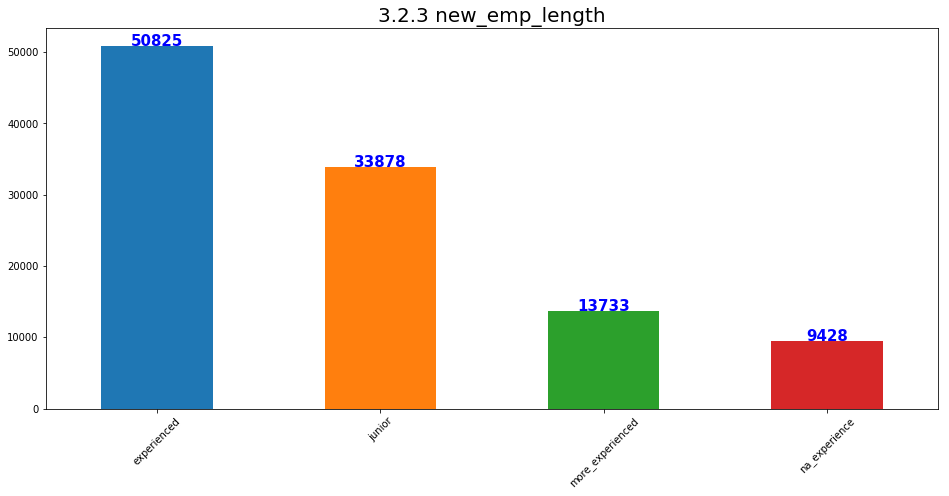

In [27]:
fig = plt.figure(figsize=(16,7))
ax = df4.toPandas().new_emp_length.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df4.toPandas().new_emp_length.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.2.3 new_emp_length',fontsize=20)

In [28]:
na_experience = spark.sql("SELECT loan_status FROM df4 WHERE new_emp_length IN ('na_experience')")
junior = spark.sql("SELECT loan_status FROM df4 WHERE new_emp_length IN ('junior')")
more_experienced = spark.sql("SELECT loan_status FROM df4 WHERE new_emp_length IN ('more_experienced')")
experienced = spark.sql("SELECT loan_status FROM df4 WHERE new_emp_length IN ('experienced')")

#### The relationship between new_emp_length and loan_status.
- Summary
    1. The distributions between junior (orange) and experienced (red) are similar to each other. Both junior and experienced dominated all the levels of loan_status.
    2. Across 'Current', 'Fully Paid', and 'In Grace Period' levels, the distributions between 'na_experience' and 'more_experienced' are similar to each other.

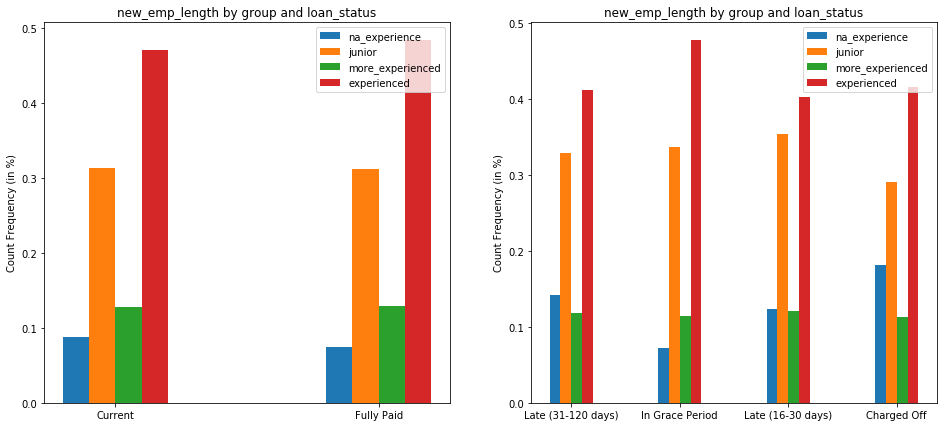

In [29]:
# Examine the relationship between new_emp_length and loan_status.
plot_cate_to_cate(data=[na_experience,junior,more_experienced,experienced],
                  total_count=total_count,
                  predictor='new_emp_length',
                  response='loan_status',
                  legend_names=['na_experience','junior','more_experienced','experienced'])

In [30]:
del df4

## 3.3 User related feature (financial specific - income)

### 3.3.1 home_ownership
- Description: The home ownership status provided by the borrower during registration. Values are: RENT, OWN, MORTGAGE, OTHER.
- Summary: Loan applicants mainly don't own their houses. They usually mortgage or rent their houses.

In [31]:
df1 = loan.select('home_ownership', 'loan_status')

Text(0.5, 1.0, '3.3.1 home_ownership')

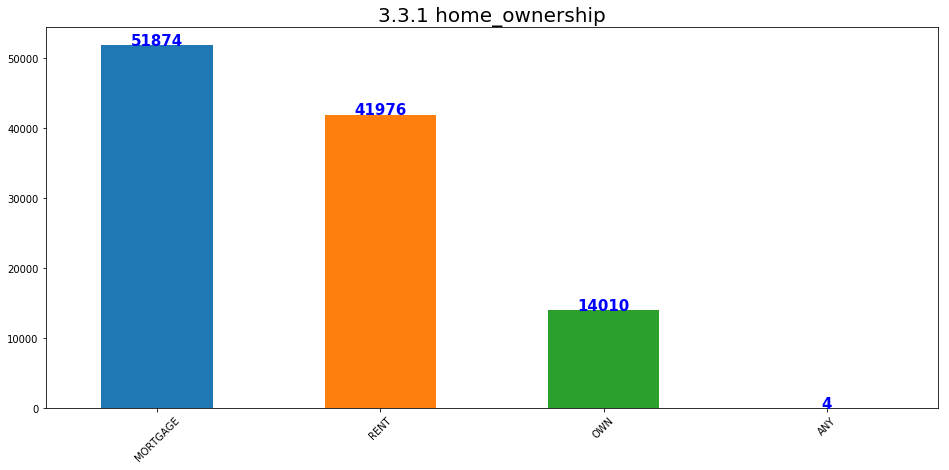

In [32]:
fig = plt.figure(figsize=(16,7))
ax = df1.toPandas().home_ownership.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df1.toPandas().home_ownership.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.3.1 home_ownership',fontsize=20)

In [33]:
sqlCtx.registerDataFrameAsTable(df1, "df1")

In [34]:
MORTGAGE = spark.sql("SELECT loan_status FROM df1 WHERE home_ownership IN ('MORTGAGE')")
RENT = spark.sql("SELECT loan_status FROM df1 WHERE home_ownership IN ('RENT')")
OWN = spark.sql("SELECT loan_status FROM df1 WHERE home_ownership IN ('OWN')")
ANY = spark.sql("SELECT loan_status FROM df1 WHERE home_ownership IN ('ANY')")

#### Relationship between home_ownership and loan_status
- Summary
    1. Across 'Current', 'Fully Paid', and 'In Grace Period' levels, distributions between 'MORTGAGE' and 'RENT' are similar to each other. Furthermore, 'MORTGAGE' dominated in 'Current', 'Fully Paid', and 'In Grace Period' levels while 'RENT' took the most part in 'Late (16-30 days)', 'Late (31-120 days)', and 'Charged Off' levels.
    2. 'OWN' seems to be equally distributed across all six levels with the range between 0.1 to 0.2. 

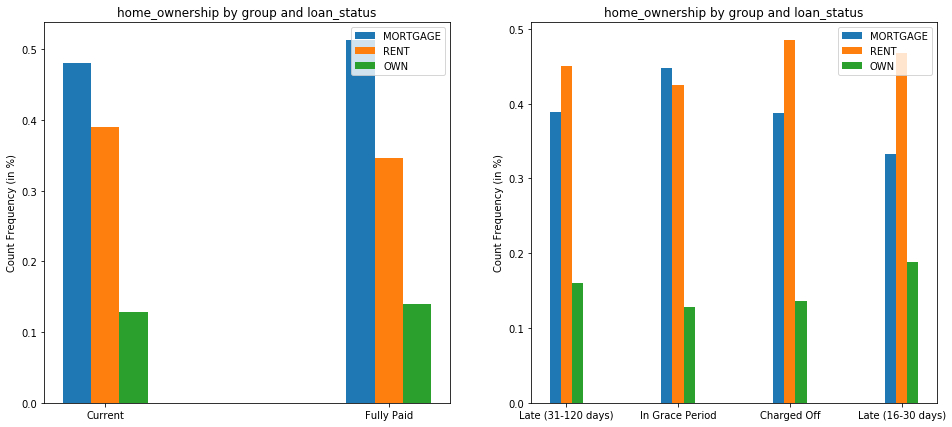

In [35]:
plot_cate_to_cate(data=[MORTGAGE, RENT, OWN],
                  total_count=total_count,
                  predictor='home_ownership',
                  response='loan_status',
                  legend_names=['MORTGAGE','RENT','OWN']
                 )

In [36]:
# Since ANY only contained two levels, in the above plot, I didn't plot group ANY.
ANY.toPandas().loan_status.value_counts()

Current       3
Fully Paid    1
Name: loan_status, dtype: int64

In [37]:
del df1

### 3.3.2 annual_inc
- Description: The self-reported annual income provided by the borrower during registration.
- Transformation: Since it's a highly right skewed distribution, I considered using binning and box-cox tranformation on annual_inc.

In [38]:
df2 = loan.select('annual_inc', 'loan_status')

Text(0.5, 1.0, '3.3.2 Box plot: annual_inc')

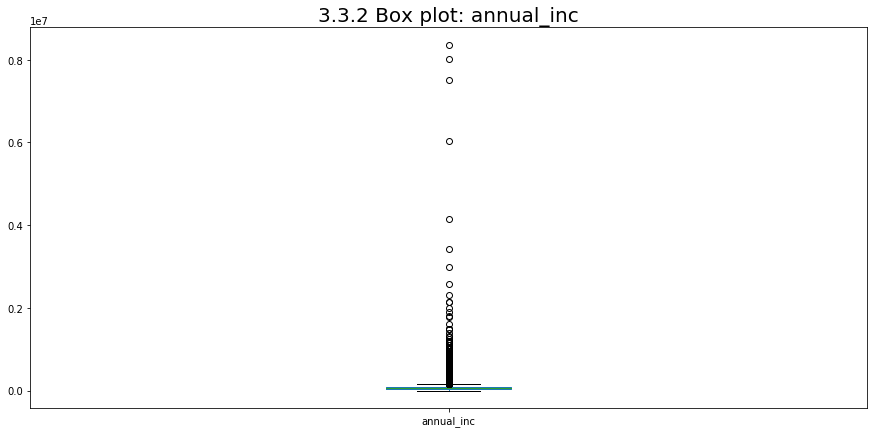

In [39]:
fig = plt.figure(figsize=(15,7))
ax = df2.toPandas().annual_inc.plot(kind = 'box')
ax.set_title('3.3.2 Box plot: annual_inc',fontsize=20)

In [40]:
# Helper function for plotting multiple boxes of predictors 
# against different levels of loan_status
def box_plot(data, predictor, response, box_cox):
    '''
    data: a spark dataframe.
    predictor: the name of an independent variable.
    response: the name of a categorical type of output variable. (e.g. loan_status)
    Output: box-plot with values that are transformed by using box-cox transformation 
    for a clear visualization.
    '''
    # Box-cox transformation.
    # Find the minimum value first bacause box-cox transformation requires positive values.
    if box_cox == True:
        # Remove na values
        no_na_data = data.toPandas()[data.toPandas()[predictor].notnull()]
        minimum_value = min(no_na_data[predictor])
        
        # Make sure the values are positive.
        if minimum_value > 0:
            transformed_values, lambda_value = boxcox(no_na_data[predictor])
        else:
            transformed_values, lambda_value = boxcox(no_na_data[predictor]+abs(minimum_value+1))
        
        # Collect levels' names of response variable.
        levels = no_na_data[response].unique()
        data_to_plot = []
        
        # Collect corresponding data using box-cox transformation for each level.
        for each in levels:
            if lambda_value != 0: 
                data_to_plot.append((no_na_data[no_na_data[response]==each][predictor]**lambda_value-1)/lambda_value)
            else:
                data_to_plot.append(np.log(no_na_data[no_na_data[response]==each][predictor]))
        
    else:
        no_na_data = data.toPandas()[data.toPandas()[predictor].notnull()]
        levels = data.toPandas()[response].unique()
        data_to_plot = []
        for each in levels:
            data_to_plot.append(no_na_data\
                                [no_na_data[response] == each][predictor])
            
    # Box-plot visualization
    fig = plt.figure(figsize=(17, 8))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(data_to_plot)
    ax.set_xticklabels([each for each in levels])
    ax.set_title('predictor: ' + predictor,fontsize=20)

#### Relationship between annual_inc and loan_status
- Summary
    1. More outliers were found in the 'Current' and 'Fully Paid' compared with the other levels. It might indicate that the annual_inc distributions of 'default' levels tend to be 'narrow'.

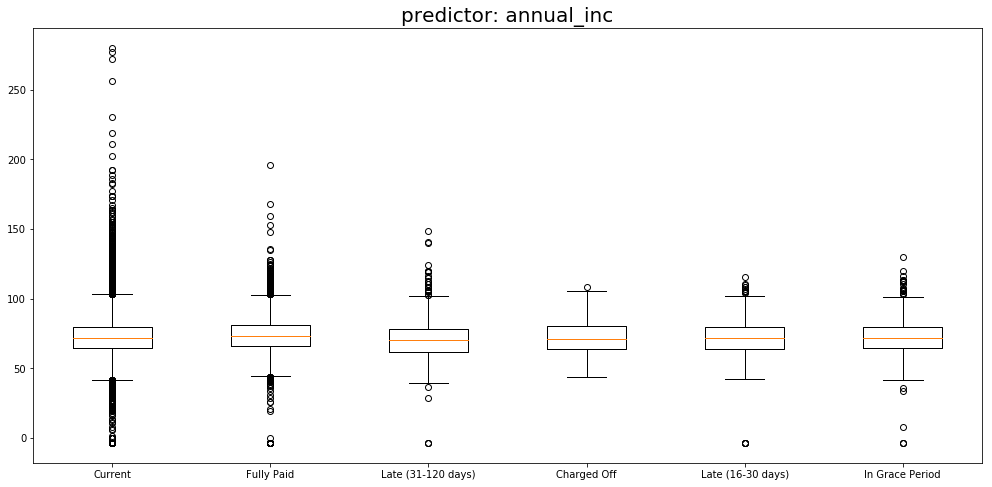

In [41]:
box_plot(data=df2, predictor='annual_inc', response='loan_status', box_cox=True)

In [42]:
del df2

### 3.3.3 verification_status
- Description: Indicates if the borrowers' income were verified by LC, not verified, or if the income source was verified.

In [43]:
df3 = loan.select('verification_status', 'loan_status')

Text(0.5, 1.0, '3.3.3 verification_status')

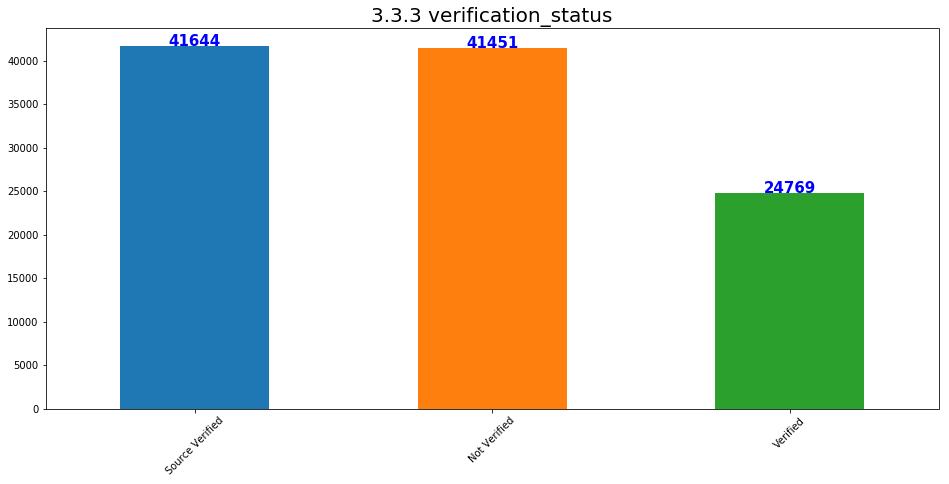

In [44]:
fig = plt.figure(figsize=(16,7))
ax = df3.toPandas().verification_status.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df3.toPandas().verification_status.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.3.3 verification_status',fontsize=20)

In [45]:
sqlCtx.registerDataFrameAsTable(df3, "df3")

In [46]:
source_verified = spark.sql("SELECT loan_status FROM df3 WHERE verification_status IN ('Source Verified')")
not_verified = spark.sql("SELECT loan_status FROM df3 WHERE verification_status IN ('Not Verified')")
verified = spark.sql("SELECT loan_status FROM df3 WHERE verification_status IN ('Verified')")

In [47]:
del df3

#### Relationship between verification_status and loan_status
- Summary
    1. Distributions between 'Late (31-120 days)' and 'Charged Off' are similar to each other. Also, distributions between 'Fully Paid' and 'In Grace Period' are similar to each other.
    2. 'Source Verified' dominated all the six levels of loan_status.

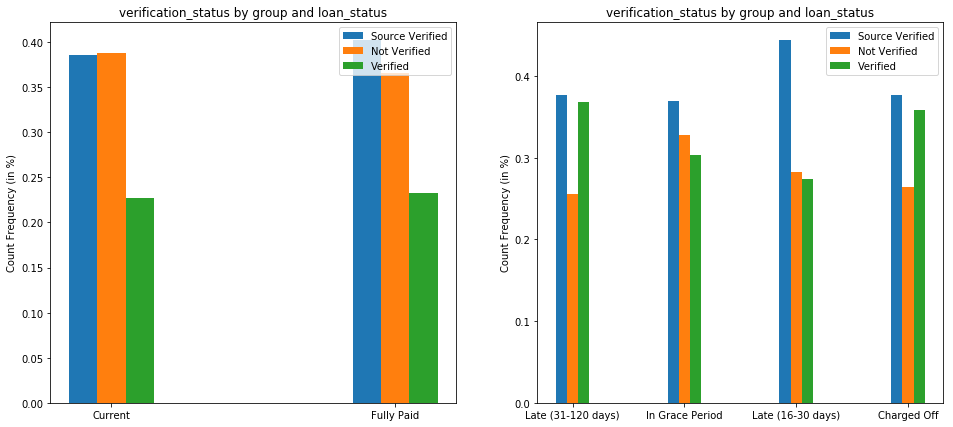

In [48]:
plot_cate_to_cate(data=[source_verified, not_verified, verified],
                  total_count=total_count,
                  predictor='verification_status',
                  response='loan_status',
                  legend_names=['Source Verified','Not Verified','Verified']
                 )

### 3.3.4 dti
- Description: A ratio calculated using the borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the borrowers' combined self-reported monthly income.
- Transformation: Since it's a highly right skewed distribution, I considered using binning and box-cox tranformation on dti.

In [49]:
df4 = loan.select('dti','loan_status')

Text(0.5, 1.0, '3.3.4 Box plot: dti')

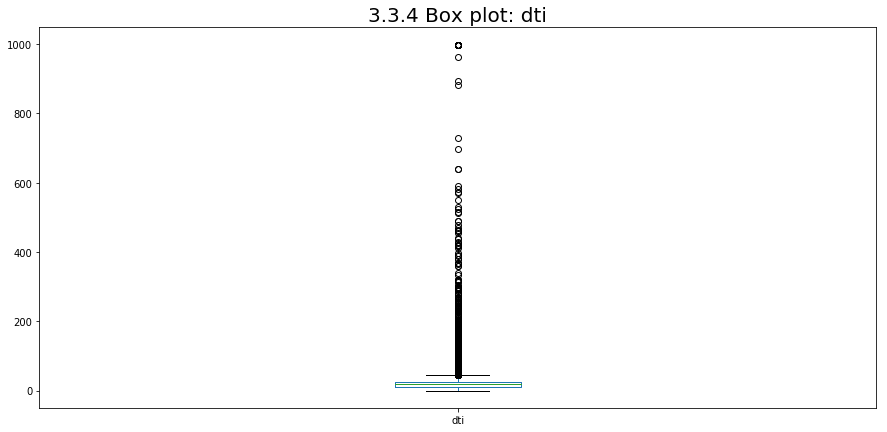

In [50]:
fig = plt.figure(figsize=(15,7))
ax = df4.toPandas().dti.plot(kind = 'box')
ax.set_title('3.3.4 Box plot: dti',fontsize=20)

#### Relationship between annual_inc and loan_status
- Summary
    1. More outliers were found in the 'Current' and 'Fully Paid' compared with the other levels. It's the similar phenomenon observed from 'annual_inc' since dti is the ratio of total debt obligations divided by the total monthly income.

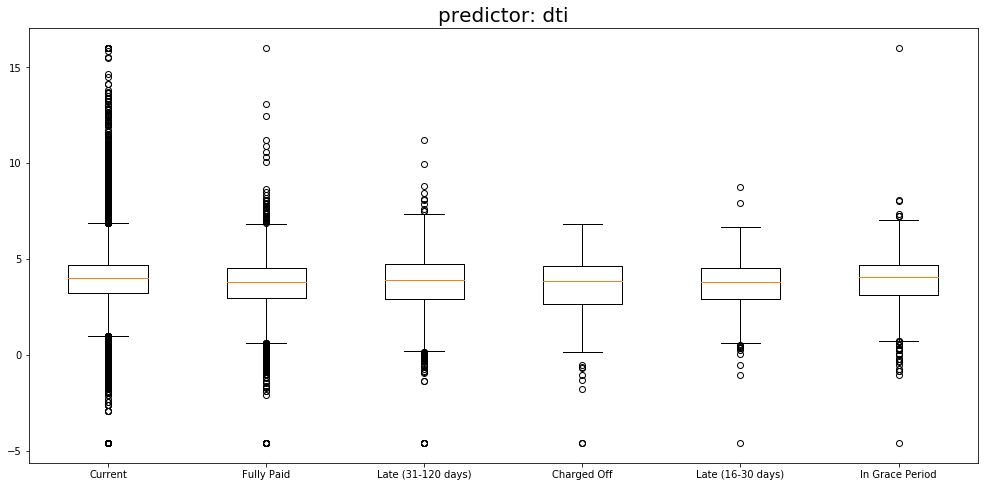

In [51]:
box_plot(data=df4, predictor='dti', response='loan_status', box_cox=True)

In [52]:
del df4

## 3.4 Loan general feature

### 3.4.1 loan_amnt 
- Description: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [53]:
df1 = loan.select('loan_amnt','loan_status')

Text(0.5, 1.0, '3.4.1 Box plot: loan_amnt')

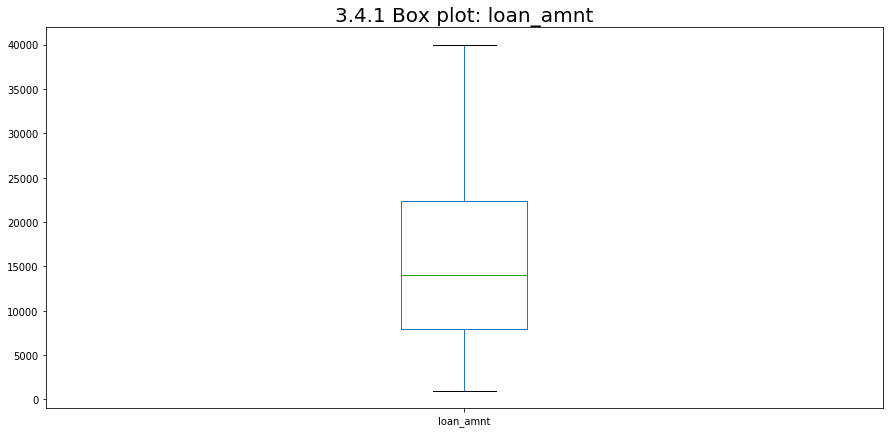

In [54]:
fig = plt.figure(figsize=(15,7))
ax = df1.toPandas().loan_amnt.plot(kind = 'box')
ax.set_title('3.4.1 Box plot: loan_amnt',fontsize=20)

#### Relationship between annual_inc and loan_status
- Summary
    1. The distributions among 'default' levels including 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)', and 'Charged Off' are similar to each other by observing the overall box distributions and median values.
    2. 'Fully Paid' has the lowest median loan_amnt followed by 'Current'.
    3. Through this box plot visualization, it might indicate that higher 'loan_amnt' resulted in higher probability of defaulting.

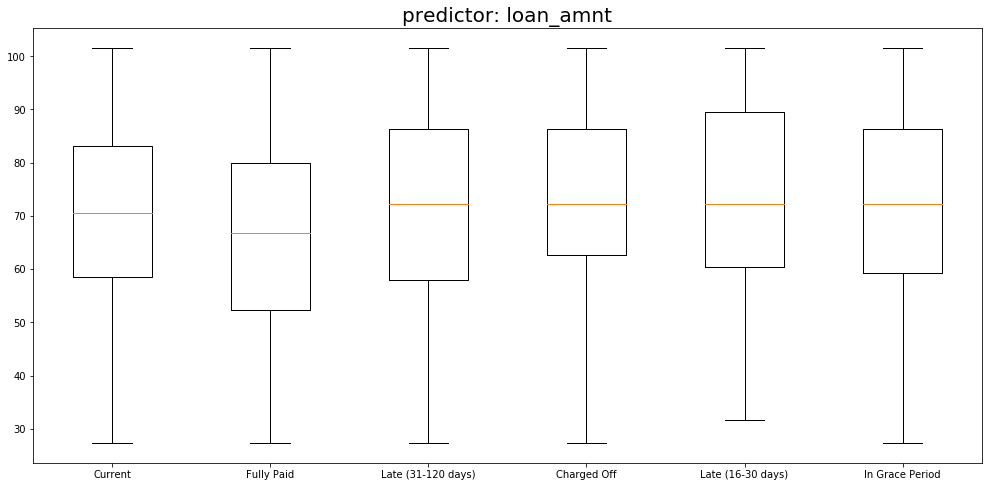

In [55]:
box_plot(data=df1, predictor='loan_amnt', response='loan_status', box_cox=True)

In [56]:
del df1

### 3.4.2 application_type 
- Description: Indicates whether the loan is an individual application or a joint application with two co-borrowers.
- Summary: About 90% of borrowers applied loans individually. 

In [57]:
df2 = loan.select('application_type', 'loan_status')

Text(0.5, 1.0, '3.4.2 application_type')

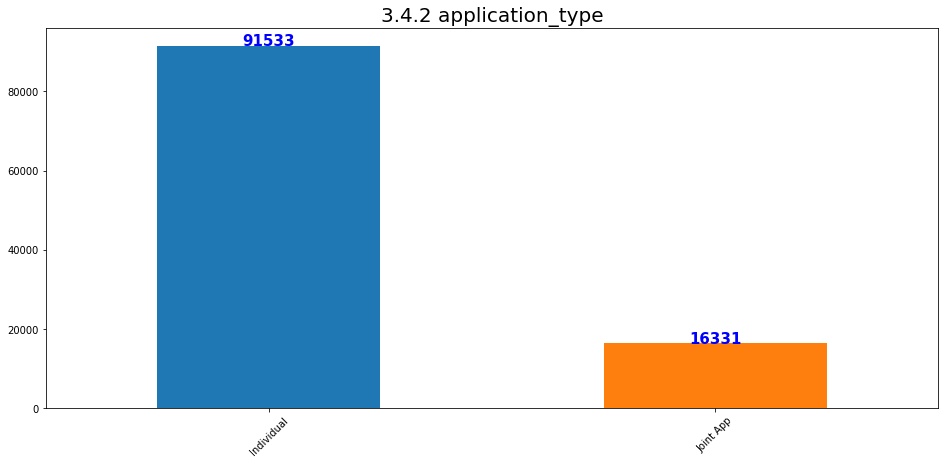

In [58]:
fig = plt.figure(figsize=(16,7))
ax = df2.toPandas().application_type.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df2.toPandas().application_type.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.4.2 application_type',fontsize=20)

In [59]:
sqlCtx.registerDataFrameAsTable(df2, "df2")

In [60]:
individual = spark.sql("SELECT loan_status FROM df2 WHERE application_type IN ('Individual')")
joint = spark.sql("SELECT loan_status FROM df2 WHERE application_type IN ('Joint App')")

#### Relationship between application_type and loan_status
- Summary
    1. Seems no clear relationship between application_type and loan_status because the distributions are similar for both 'Individual' and 'Joint App' across six levels.

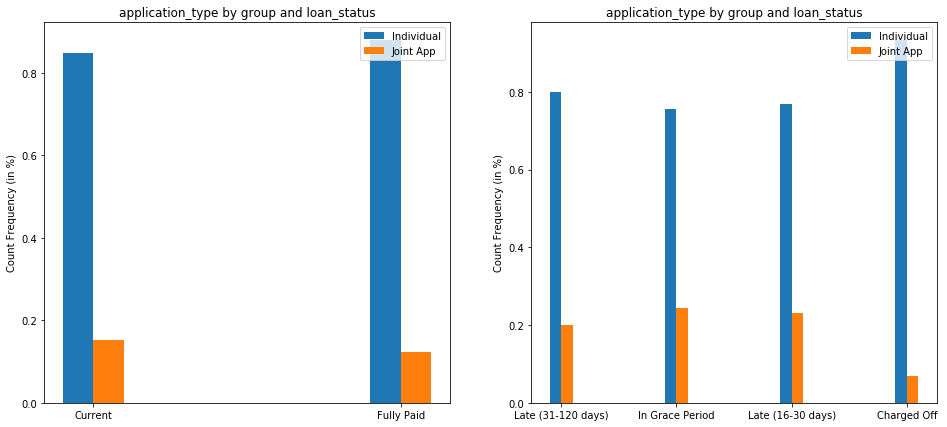

In [61]:
plot_cate_to_cate(data=[individual,joint],
                  total_count=total_count,
                  predictor='application_type',
                  response='loan_status',
                  legend_names=['Individual','Joint App']
                 )

In [62]:
del df2

### 3.4.3 purpose
- Description: A category provided by the borrower for the loan request. 
- Transformation: Condensed 13 levels into 5 levels by grouping 'home_improvement','house', and 'moving' into 'home' group, and by grouping 'major_purchase','medical','car','small_business','vacation','moving','renewable_energy', and 'wedding' into 'major_purchase' group.

In [63]:
df3 = loan.select('purpose', 'loan_status')

Text(0.5, 1.0, '3.4.3 purpose')

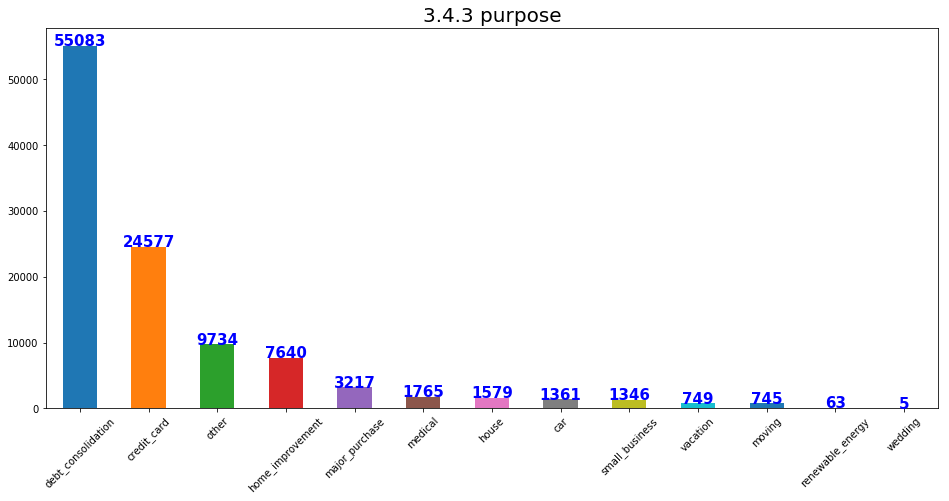

In [64]:
fig = plt.figure(figsize=(16,7))
ax = df3.toPandas().purpose.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df3.toPandas().purpose.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.4.3 purpose',fontsize=20)

In [65]:
del df3

In [66]:
query_1 = "SELECT CASE WHEN purpose IN ('debt_consolidation') THEN 'debt_consolidation' \
WHEN purpose IN ('credit_card') THEN 'credit_card' \
WHEN purpose IN ('other') THEN 'other' \
WHEN purpose IN ('home_improvement','house','moving') THEN 'home' \
ELSE 'major_purchase' END AS new_purpose, loan_status FROM loan"

In [67]:
df4 = spark.sql(query_1)

Text(0.5, 1.0, '3.4.3 new_purpose')

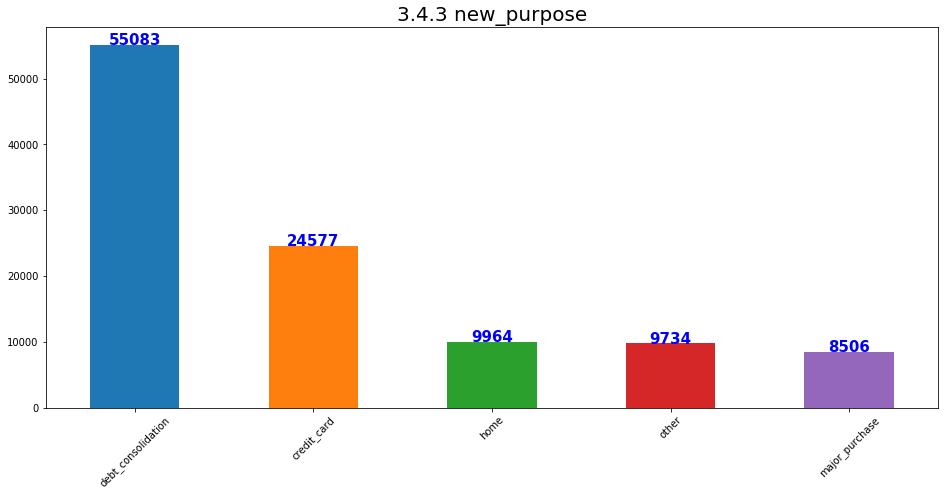

In [68]:
fig = plt.figure(figsize=(16,7))
ax = df4.toPandas().new_purpose.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df4.toPandas().new_purpose.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.4.3 new_purpose',fontsize=20)

In [69]:
sqlCtx.registerDataFrameAsTable(df4, "df4")

In [70]:
debt_con = spark.sql("SELECT loan_status FROM df4 WHERE new_purpose IN ('debt_consolidation')")
credit_card = spark.sql("SELECT loan_status FROM df4 WHERE new_purpose IN ('credit_card')")
other = spark.sql("SELECT loan_status FROM df4 WHERE new_purpose IN ('other')")
home = spark.sql("SELECT loan_status FROM df4 WHERE new_purpose IN\
('home')")
major_purchase = spark.sql("SELECT loan_status FROM df4 WHERE new_purpose IN\
('major_purchase')")

In [71]:
del df4

#### Relationship between new_purpose and loan_status
- Summary
    1. Distributions between 'Late (31-120 days)' and 'Charged Off' are similar to each other. Also, distributions between 'Current' and 'Fully Paid' are similar to each other.

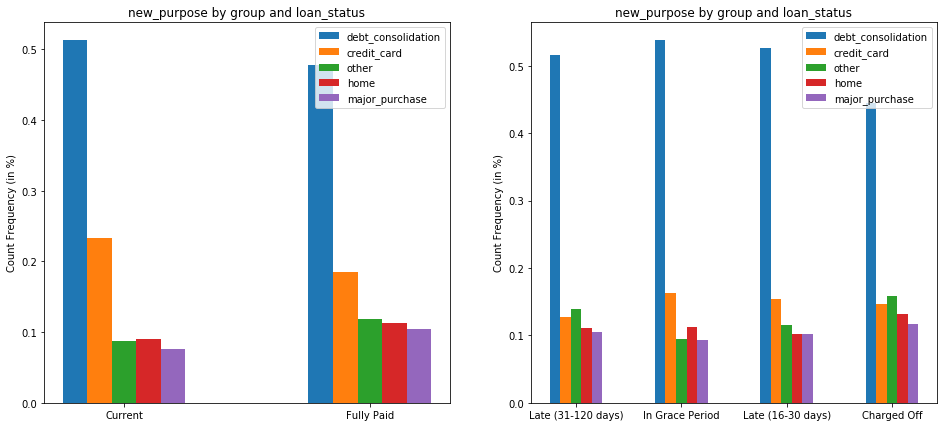

In [72]:
plot_cate_to_cate(data=[debt_con,credit_card,other,home,major_purchase],
                  total_count=total_count,
                  predictor='new_purpose',
                  response='loan_status',
                  legend_names=['debt_consolidation','credit_card','other',
                                'home','major_purchase']
                 )

### 3.4.4 term
- Description: The number of payments on the loan. Values are in months and can be either 36 or 60.

In [73]:
df5 = loan.select('term', 'loan_status')

Text(0.5, 1.0, '3.4.4 term')

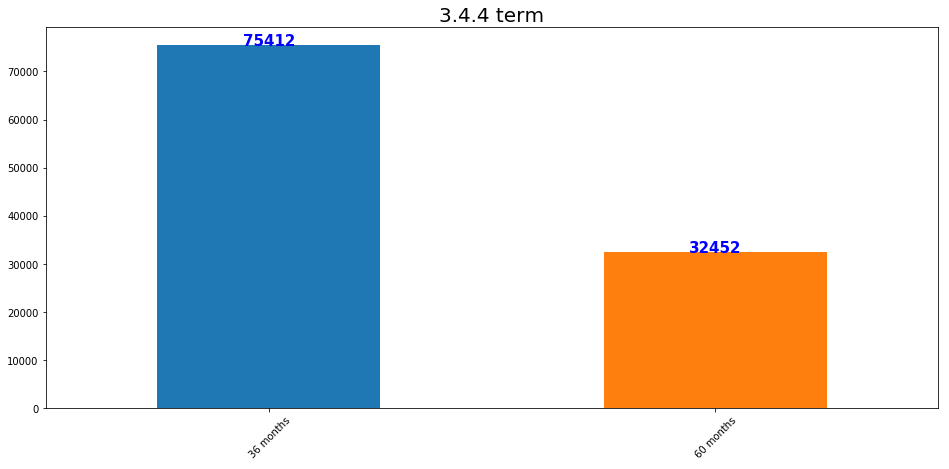

In [74]:
fig = plt.figure(figsize=(16,7))
ax = df5.toPandas().term.value_counts().plot(kind = 'bar', rot = 45)
for i, v in enumerate(df5.toPandas().term.value_counts()):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('3.4.4 term',fontsize=20)

In [75]:
sqlCtx.registerDataFrameAsTable(df5, "df5")

In [76]:
months_36 = spark.sql("SELECT loan_status FROM df5 WHERE term IN (' 36 months')")
months_60 = spark.sql("SELECT loan_status FROM df5 WHERE term IN (' 60 months')")

In [77]:
del df5

#### Relationship between term and loan_status
- Summary
    1. Distributions between 'Late (31-120 days)' and 'Charged Off' are similar to each other. Also, distributions among the rest of levels are similar to each other.

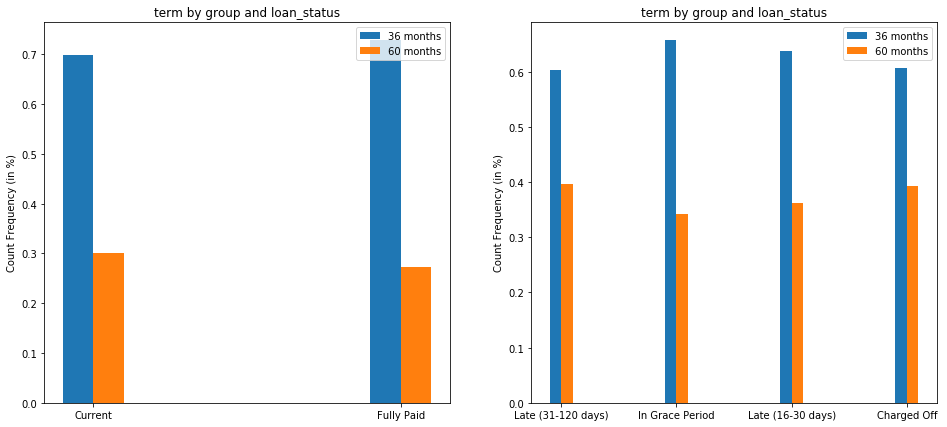

In [78]:
plot_cate_to_cate(data=[months_36,months_60],
                  total_count=total_count,
                  predictor='term',
                  response='loan_status',
                  legend_names=['36 months','60 months']
                 )

In [79]:
len(loan.select('title').toPandas()['title'].unique())

12

### 3.4.5 installment
- Description: The monthly payment owed by the borrower if the loan originates.

In [80]:
df6 = loan.select('installment','loan_status')

Text(0.5, 1.0, '3.4.5 Box plot: installment')

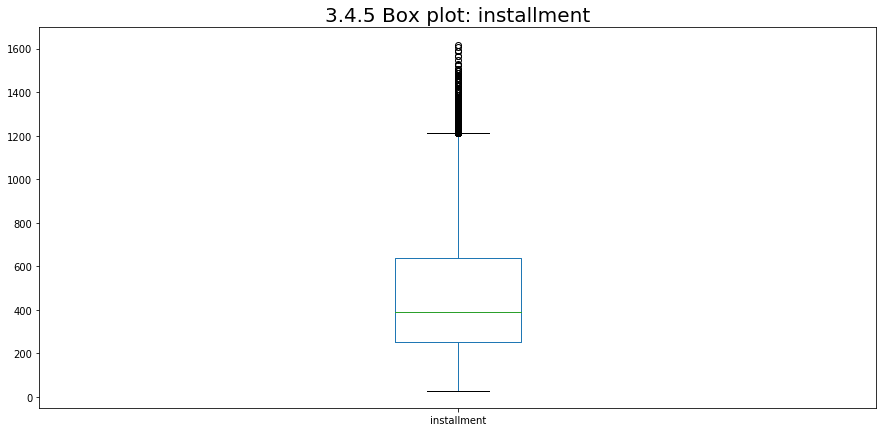

In [81]:
fig = plt.figure(figsize=(15,7))
ax = df6.toPandas().installment.plot(kind = 'box')
ax.set_title('3.4.5 Box plot: installment',fontsize=20)

#### Relationship between installment and loan_status
- Summary (same as 'loan_amnt')
    1. The distributions among 'default' levels including 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)', and 'Charged Off' are similar to each other by observing the overall box distributions and median values.
    2. 'Fully Paid' has the lowest median loan_amnt followed by 'Current'.
    3. Through this box plot visualization, it might indicate that higher 'installment' resulted in higher probability of defaulting.

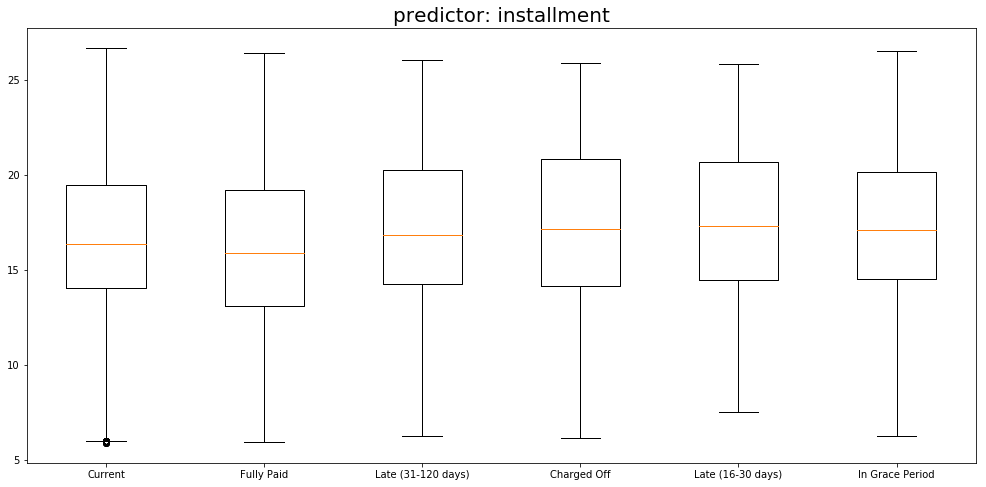

In [82]:
box_plot(data=df6, predictor='installment', response='loan_status', box_cox=True)

In [83]:
del df6

### 3.4.6 funded_amnt
- Description: The total amount committed to that loan at that point in time.

In [84]:
df7 = loan.select('funded_amnt','loan_status')

Text(0.5, 1.0, '3.4.6 Box plot: funded_amnt')

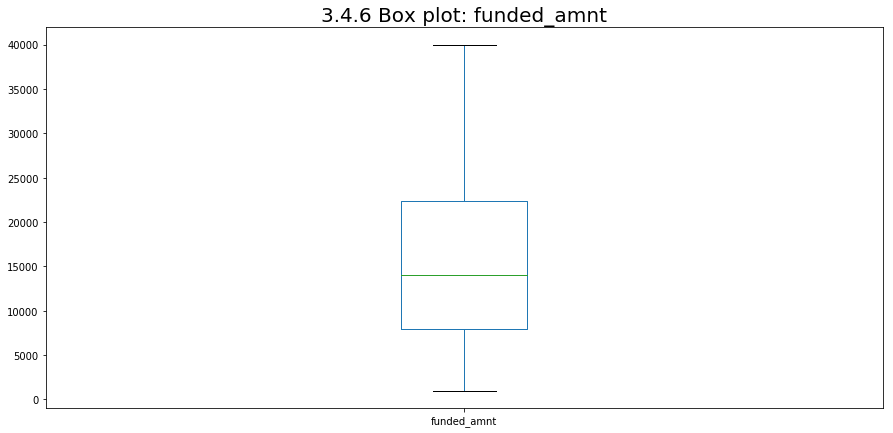

In [85]:
fig = plt.figure(figsize=(15,7))
ax = df7.toPandas().funded_amnt.plot(kind = 'box')
ax.set_title('3.4.6 Box plot: funded_amnt',fontsize=20)

#### Relationship between funded_amnt and loan_status
- Summary: Same as 'loan_amnt' and 'installment'.

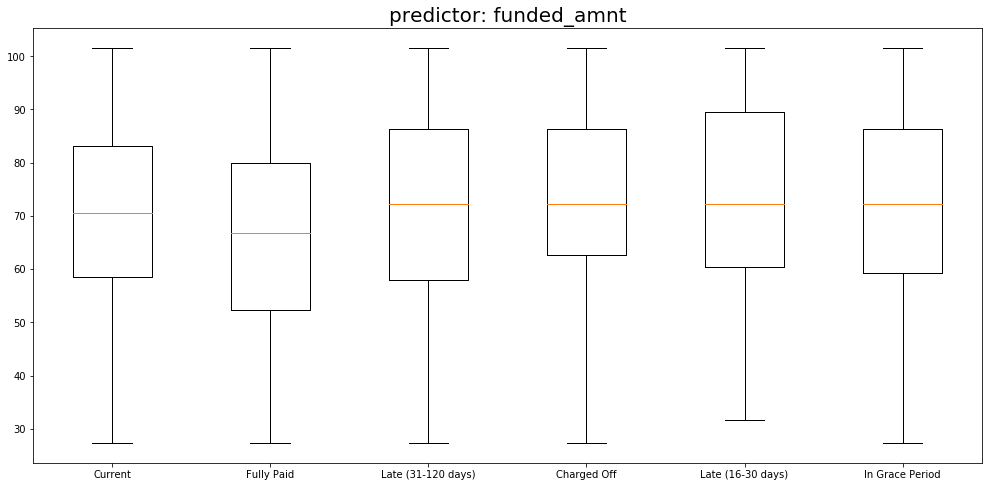

In [86]:
box_plot(data=df7, predictor='funded_amnt', response='loan_status', box_cox=True)